<h1 style="color: #5ca3d6; text-align: center;">Classifying Severity of Alzheimer's Disease - LBP</h1>

In [1]:
from skimage import feature
import numpy as np
import cv2
import os

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from joblib import dump, load
from localbinarypatterns import LocalBinaryPatterns
import helper

<h3 style="font-weight: normal;">Helper class for LPB</h3>

In [2]:
class LocalBinaryPatterns:
    def __init__(self, num_points, radius):
        # store the number of points and radius
        self.num_points = num_points
        self.radius = radius

    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.num_points, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.num_points + 3), range=(0, self.num_points + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist

<h3 style="font-weight: normal;">Constants</h3>

In [3]:
DATASET_PATH = '..' + os.path.sep + 'dataset'
IMAGE_SIZE = (128, 128)

<h3 style="font-weight: normal;">Reading image paths and labels and writing to dictionary</h3>

Iterrating through dataset's directories and files and creating dictionary with <span style="font-style: italic;">"path/to/file" : "label"</span> pairs. <br/>
Also, creating classes list, which is a list with names of all classes. Possible Alzheimer stages (classes) are: non demented, mild demented, very mild demented and moderate demented.

In [4]:
images_dict = dict()
classes = []
for root, dirs, files in os.walk(DATASET_PATH):
    path = root.split(os.sep)
    for directory in dirs:
        classes.append(directory)

    for file in files:
        if len(path) == 3:
            if path[2] == 'MildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 0
            elif path[2] == 'ModerateDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 1
            elif path[2] == 'NonDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 2
            elif path[2] == 'VeryMildDemented':
                images_dict[os.path.join(DATASET_PATH, path[2], file)] = 3

class_number = len(classes)
classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

<h3 style="font-weight: normal;">Loading images</h3>

Creating two lists: <span style="font-style: italic;">train_images</span>, which is a list of loaded images, and <span style="font-style: italic;">train_image_labels</span>, which is a list of labels for each image.

In [5]:
train_images = []
train_image_labels = []
for image_path, image_label in images_dict.items():
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    train_images.append(img)
    train_image_labels.append(image_label)

train_images = np.array(train_images, dtype=float)
train_image_labels = np.array(train_image_labels, dtype=float)

<h3 style="font-weight: normal;">Split to train and test</h3>

In [6]:
train_images, test_images, train_image_labels, test_image_labels = train_test_split(
    train_images,
    train_image_labels,
    test_size=0.2,
    random_state=15,
    stratify=train_image_labels)

train_images = train_images / 255
test_images = test_images / 255

<h3 style="font-weight: normal;">Oversampling</h3>

In [7]:
sm = SMOTE(random_state=42)
train_images, train_image_labels = sm.fit_resample(train_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), 
                                                   train_image_labels)
train_images = train_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


test_images, test_image_labels = sm.fit_resample(test_images.reshape(-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3), 
                                                 test_image_labels)
test_images = test_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

<h3 style="font-weight: normal;">Shuffling data</h3>

In [8]:
train_images, train_image_labels = shuffle(train_images, train_image_labels)

<h3 style="font-weight: normal;">Creating and training model</h3>

In [64]:
try:
    clf_svm = load('models/svm.joblib')
except:
    train_image_features = []

    desc = LocalBinaryPatterns(8, 1)

    for img in train_images:
        img = helper.reshape_data(img)
        hist = desc.describe(img)
        train_image_features.append(hist)

    x = np.array(train_image_features)
    y = np.array(train_image_labels)

    # x = helper.reshape_data(x)

    clf_svm = LinearSVC(C=50.0, random_state=42, verbose=1, max_iter=20000)
    clf_svm.fit(x, y)

    dump(clf_svm, 'models/svm.joblib')

[LibLinear]

<h3 style="font-weight: normal;">Predicting</h3>

In [61]:
test_image_features = []
desc_test = LocalBinaryPatterns(8, 1)

for img in test_images:
    img = helper.reshape_data(img)
    hist = desc_test.describe(img)
    test_image_features.append(hist)
print("LBP done for test images")

x = np.array(test_image_features)
y = np.array(test_image_labels)

predictions = clf_svm.predict(x)
print(predictions)

LBP done for test images
[2. 2. 2. ... 1. 1. 0.]


<h2 style="font-weight: normal;">Statistics</h2>

In [57]:
test_image_labels_str = []
for label in test_image_labels:
    test_image_labels_str.append(classes[int(label)])
    
predicted_labels_str = []
for label in predictions:
    predicted_labels_str.append(classes[int(label)])

<h4 style="font-weight: normal;">Confusion matrix</h4>

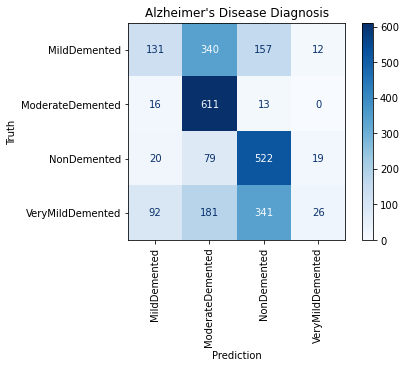

In [58]:
conf_mat = confusion_matrix(test_image_labels_str, predicted_labels_str, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
disp.plot(cmap="Blues", values_format='', xticks_rotation=90)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

<h4 style="font-weight: normal;">Accuracy</h4>

In [59]:
percentage = accuracy_score(test_image_labels_str, predicted_labels_str)*100
print('Accuracy:', percentage, '%')

Accuracy: 50.390625 %


<h4 style="font-weight: normal;">Classification report</h4>

In [62]:
print(classification_report(y_true=list(map(str, test_image_labels_str)),
                            y_pred=list(map(str, predicted_labels_str)),
                            target_names=list(map(str, classes))))

                  precision    recall  f1-score   support

    MildDemented       0.51      0.20      0.29       640
ModerateDemented       0.50      0.95      0.66       640
     NonDemented       0.51      0.82      0.62       640
VeryMildDemented       0.46      0.04      0.07       640

        accuracy                           0.50      2560
       macro avg       0.49      0.50      0.41      2560
    weighted avg       0.49      0.50      0.41      2560

